<a href="https://colab.research.google.com/github/robinson-oliveira/mlops_train/blob/main/Vivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problema**: Queda na nota de satisfação da pesquisa digital sobre o atendimento do *call center*;<br>
**Objetivo**: Propor soluções para contornar a insatisfação dos clientes e, consequentemente, aumentar a nota da pesquisa.

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
xls = pd.ExcelFile('My Drive/Colab Notebooks/Case_Envio_Candidatex.xlsx')
pesquisa = xls.parse(1)
status = xls.parse(2)
servicos = xls.parse(3)

In [4]:
data = pesquisa.merge(status, on='ID_CLIENTE').merge(servicos, on='ID_PLNO')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID_CLIENTE          1000 non-null   int64         
 1   DATA_PESQUISA       1000 non-null   datetime64[ns]
 2   1.NOTA_PESQUISA     1000 non-null   int64         
 3   2.MOTIVO_LIGAÇÃO    1000 non-null   object        
 4   3.MOTIVO_AVALIAÇÃO  432 non-null    object        
 5   4.ABERTA            483 non-null    object        
 6   STATUS_ATUAL        1000 non-null   object        
 7   RECHAMADAS          1000 non-null   int64         
 8   ID_PLNO             1000 non-null   int64         
 9   SEGMENTO            1000 non-null   object        
 10  PLANO               1000 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 93.8+ KB


Para os atributos "3.MOTIVO_AVALIAÇÃO" e "4.ABERTA" há mais de 50% de valores ausentes.

In [6]:
data.duplicated().sum()

0

Não existem valores duplicados no conjunto de dados.

In [7]:
data.head(5)

,ID_CLIENTE,DATA_PESQUISA,1.NOTA_PESQUISA,2.MOTIVO_LIGAÇÃO,3.MOTIVO_AVALIAÇÃO,4.ABERTA,STATUS_ATUAL,RECHAMADAS,ID_PLNO,SEGMENTO,PLANO
0,1185,2020-03-30,1,Discordo dos valores cobrados na minha conta,Demorou muito tempo para eu falar com o atendente,Voltando o sinal no meu chip. Tem 4 dias que n...,ATIVO,1,352,CONTROLE,"3,5GB"
1,1844,2020-03-04,1,Discordo dos valores cobrados na minha conta,"Não gostei do atendente (educação, conheciment...",Vocês não tem empatia c o cliente,ATIVO,8,352,CONTROLE,"3,5GB"
2,1685,2020-04-05,1,Queria informar o pagamento de conta atrasada,NaN,vendendo o produto e assumindo tudo em relação...,ATIVO,2,352,CONTROLE,"3,5GB"
3,1160,2020-01-01,1,Queria saber sobre planos e promoções,"Não gostei do atendente (educação, conheciment...",Valores estão altos demais comparado as outras...,ATIVO,7,352,CONTROLE,"3,5GB"
4,1081,2020-04-16,1,Queria solicitar segunda via da minha conta,Minha solicitação não foi resolvida,Uma maneira mais fácil de se falar com Suport...,ATIVO,2,352,CONTROLE,"3,5GB"


Verificando um registro com status "CANCELADO" qualquer:

In [8]:
data.loc[data['ID_CLIENTE']==1360]

,ID_CLIENTE,DATA_PESQUISA,1.NOTA_PESQUISA,2.MOTIVO_LIGAÇÃO,3.MOTIVO_AVALIAÇÃO,4.ABERTA,STATUS_ATUAL,RECHAMADAS,ID_PLNO,SEGMENTO,PLANO
525,1360,2020-01-10,1,Discordo dos valores cobrados na minha conta,Demorou muito tempo para eu falar com o atendente,Treinando melhor os funcionários que são DESCO...,CANCELADO,5,351,CONTROLE,5GB


Verificando o número de datas únicas no conjunto de dados:

In [9]:
data['DATA_PESQUISA'].nunique()

62

Visualizando os dados:

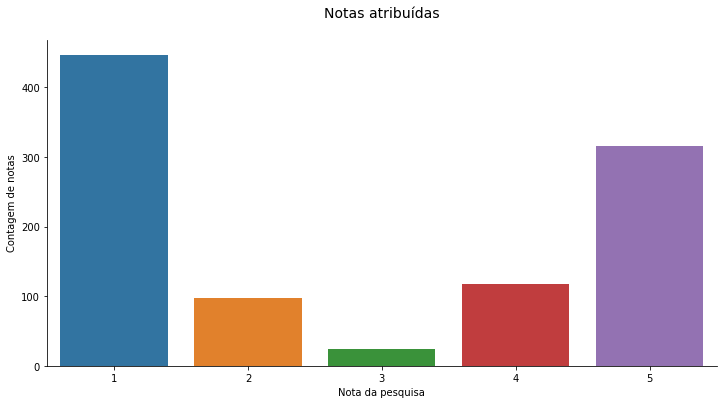

In [10]:
ax = sns.countplot(x="1.NOTA_PESQUISA", data=data)
ax.figure.set_size_inches(12,6)
ax.set_title('Notas atribuídas\n', fontsize=14)
ax.set_xlabel('Nota da pesquisa', fontsize=10)
ax.set_ylabel('Contagem de notas', fontsize=10)
sns.despine(ax=ax);
plt.savefig('My Drive/Colab Notebooks/fig_01.png', format='png', dpi=600, bbox_inches='tight')

In [11]:
data['1.NOTA_PESQUISA'].value_counts(normalize=True).sort_index().cumsum()

1    0.446
2    0.543
3    0.567
4    0.685
5    1.000
Name: 1.NOTA_PESQUISA, dtype: float64

Se classificássemos os clientes que atribuíram notas 1, 2 e 3 como detratores e 4 e 5 como promotores, teríamos aproximadamente 57% da base classificada como detratores. Criarei uma flag na base para quem sabe explorar essa ideia futuramente.

In [12]:
data['NPS'] = np.where((data['1.NOTA_PESQUISA']<4), 1, 0)

In [13]:
data['NPS'].value_counts(normalize=True)

1    0.567
0    0.433
Name: NPS, dtype: float64

Como o grupo que atribuiu nota 1 é o mais representativo, faz sentido explorá-lo para identificarmos os principais motivos:

In [14]:
data.loc[data['1.NOTA_PESQUISA'] == 1]['2.MOTIVO_LIGAÇÃO'].value_counts(normalize=True).cumsum()

Discordo dos valores cobrados na minha conta     0.381166
Queria informar o pagamento de conta atrasada    0.634529
Queria saber sobre planos e promoções            0.802691
Queria solicitar segunda via da minha conta      0.968610
Minha Internet não funcionava ou estava lenta    1.000000
Name: 2.MOTIVO_LIGAÇÃO, dtype: float64

Neste grupo, a discordância dos valores cobrados e o aviso de pagamento correspondem a 63% dos casos.<br><br>Minha ideia é visualizar se essa caraterística também é observada em outros grupos.<br><br>Primeiramente as contagens:

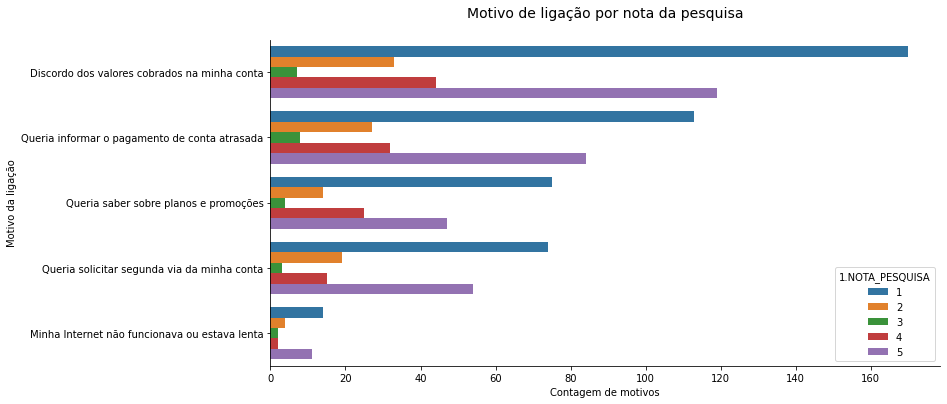

In [15]:
ax = sns.countplot(y="2.MOTIVO_LIGAÇÃO", hue="1.NOTA_PESQUISA", data=data)
ax.figure.set_size_inches(12,6)
ax.set_title('Motivo de ligação por nota da pesquisa\n', fontsize=14)
ax.set_ylabel('Motivo da ligação', fontsize=10)
ax.set_xlabel('Contagem de motivos', fontsize=10)
sns.despine(ax=ax);
plt.savefig('My Drive/Colab Notebooks/fig_02.png', format='png', dpi=600, bbox_inches='tight')

Visualmente, parece haver uma distribuição mais ou menos igualitária de notas à proporção do motivo de ligação.<br><br>Para validação, irei visualizá-las proporcionalmente:

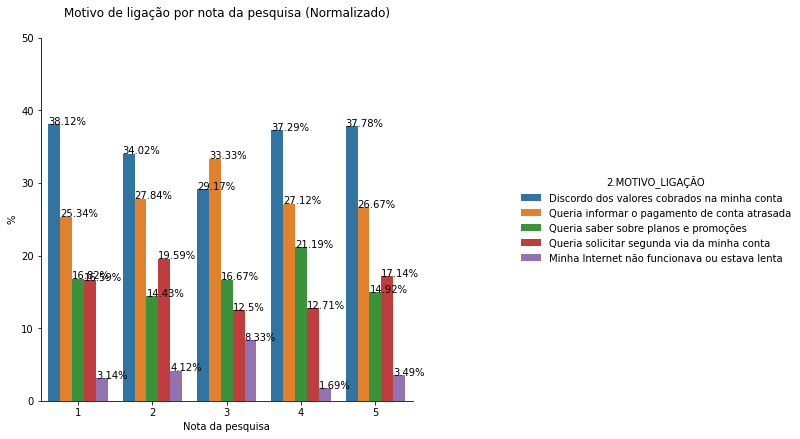

In [16]:
x, y = '1.NOTA_PESQUISA', '2.MOTIVO_LIGAÇÃO'

aux = data.groupby(x)[y].value_counts(normalize=True)
aux = aux.mul(100)
aux = aux.rename('%').reset_index()

g = sns.catplot(x=x, y='%', hue=y, kind='bar', data=aux)
g.figure.set_size_inches(12,6)
g.set(title="Motivo de ligação por nota da pesquisa (Normalizado)\n", xlabel="Nota da pesquisa")
g.ax.set_ylim(0, 50)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x, txt_y, txt)

plt.savefig('My Drive/Colab Notebooks/fig_03.png', format='png', dpi=600, bbox_inches='tight')

Percepção confirmada. A única exceção, irrelevante dada a frequência para esta nota, é o grupo de usuários que atribuiu o conceito 3.<br><br>Desejo agora uma visualização semelhante, com o motivo da ligação por segmento do cliente:

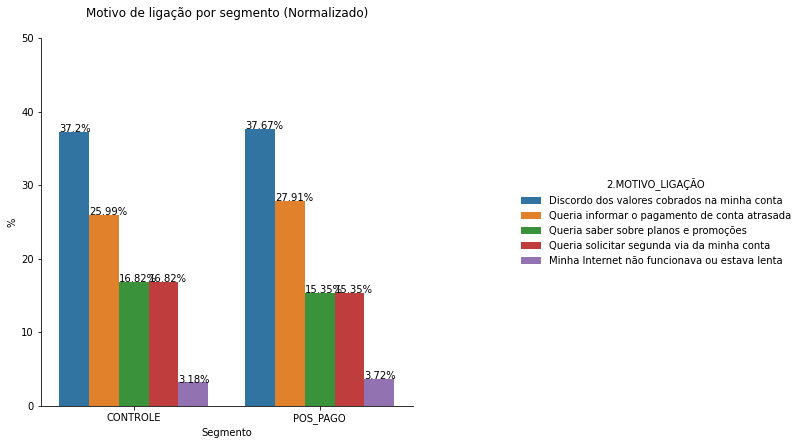

In [17]:
x, y = 'SEGMENTO ', '2.MOTIVO_LIGAÇÃO'

aux = data.groupby(x)[y].value_counts(normalize=True)
aux = aux.mul(100)
aux = aux.rename('%').reset_index()

g = sns.catplot(x=x, y='%', hue=y, kind='bar', data=aux)
g.figure.set_size_inches(12,6)
g.set(title="Motivo de ligação por segmento (Normalizado)\n", xlabel="Segmento")
g.ax.set_ylim(0, 50)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x, txt_y, txt)

plt.savefig('My Drive/Colab Notebooks/fig_04.png', format='png', dpi=600, bbox_inches='tight')

Sob esse ponto de vista, nada a agregar. Minha intuição era a de que talvez encontrasse características distintas entre esses grupos, pois certamente o valor do cliente é significativamente diferente.<br><br>Ainda explorando o grupo que atribuiu nota 1, cruzarei esta informação com os motivos da avaliação (atributo com grande número de valores ausentes):

In [18]:
data.loc[data['1.NOTA_PESQUISA'] == 1]['3.MOTIVO_AVALIAÇÃO'].value_counts(normalize=True).cumsum()

Demorou muito tempo para eu falar com o atendente                                                          0.504878
Minha solicitação não foi resolvida                                                                        0.770732
Não gostei do atendente (educação, conhecimento, vontade de ajudar)                                        0.865854
As informações passadas não foram claras                                                                   0.943902
Fui direcionado para outro canal (Loja/Meu Vivo/Atendimento eletrônico) para resolver minha solicitação    1.000000
Name: 3.MOTIVO_AVALIAÇÃO, dtype: float64

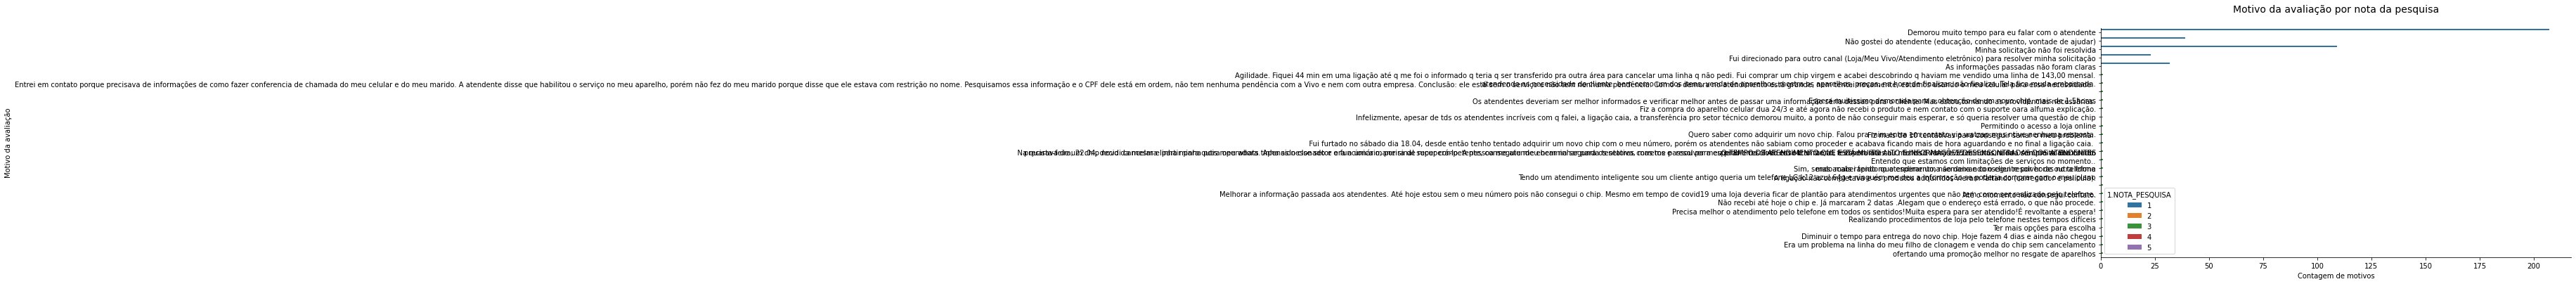

In [19]:
ax = sns.countplot(y="3.MOTIVO_AVALIAÇÃO", hue="1.NOTA_PESQUISA", data=data)
ax.figure.set_size_inches(12,6)
ax.set_title('Motivo da avaliação por nota da pesquisa\n', fontsize=14)
ax.set_ylabel('Motivo da avaliação', fontsize=10)
ax.set_xlabel('Contagem de motivos', fontsize=10)
sns.despine(ax=ax);
plt.savefig('My Drive/Colab Notebooks/fig_05.png', format='png', dpi=600, bbox_inches='tight')

Como a visualização restou prejudicada em função do número de categorias (para além do grande número de valores ausentes), não estenderei a análise para este atributo.<br><br>Concluindo, sob a perspectiva do motivo da ligação, os fatores: (1) discordância dos valores cobrados e (2) aviso de pagamento são os mais relevantes. Para o motivo da avaliação, a (3) demora no tempo para se falar com o atendente e a (4) não resolução do problema são os principais ofensores.<br><br>Consequentemente, estes serão os problemas que precisam ser "atacados".

In [20]:
from matplotlib.ticker import PercentFormatter

def pareto_plot(df, att):
    df_tmp = pd.DataFrame(df[att].value_counts())
    df_tmp['ACC'] = df_tmp[att].cumsum()
    df_tmp['ACC%'] = ((df_tmp['ACC']/df_tmp[att].sum())*100).round(2)
    aux = df_tmp[df_tmp['ACC%'] <= 95.00].shape[0]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax = sns.barplot(df_tmp.index[0:aux], df_tmp[att][0:aux], color='C4')
    ax.set_title(att)
    ax2 = ax.twinx()
    ax2.plot(df_tmp.index[0:aux], df_tmp['ACC%'][0:aux], color='C3', marker='D', ms=4)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_ylabel('Contagem')
    ax2.tick_params(axis='y', colors='C3')

    plt.gcf().set_size_inches(12, 6)
    return plt.show()

Visualizando um pareto para diferentes atributos:

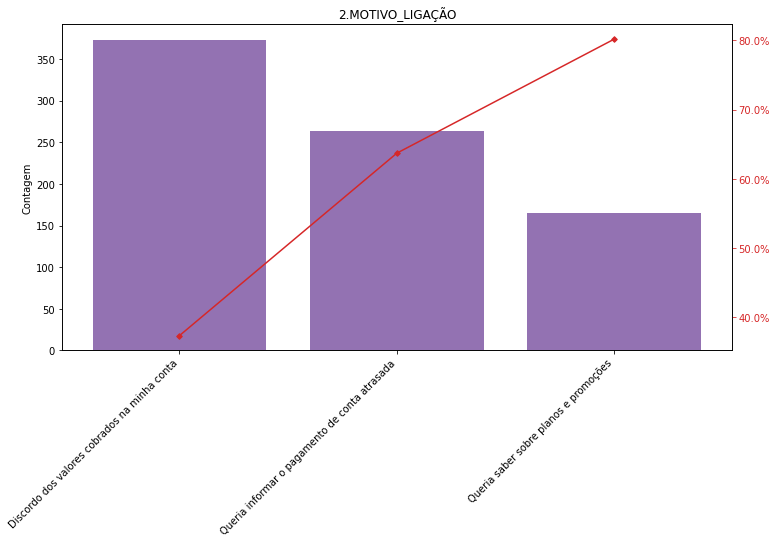

<Figure size 432x288 with 0 Axes>

In [21]:
pareto_plot(data, '2.MOTIVO_LIGAÇÃO')
plt.savefig('My Drive/Colab Notebooks/fig_06.png', format='png', dpi=600, bbox_inches='tight')

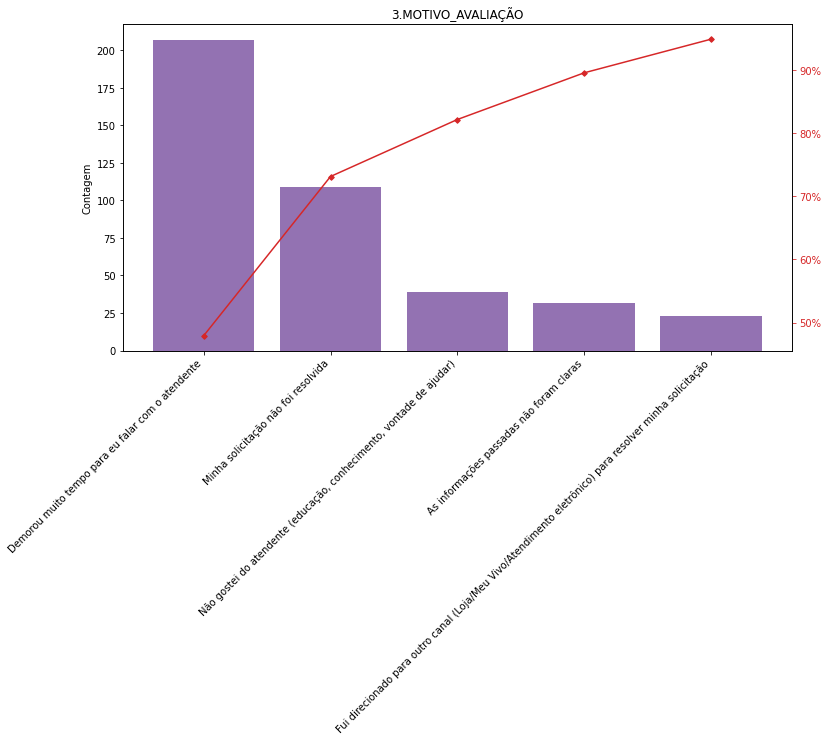

<Figure size 432x288 with 0 Axes>

In [22]:
pareto_plot(data, '3.MOTIVO_AVALIAÇÃO')
plt.savefig('My Drive/Colab Notebooks/fig_07.png', format='png', dpi=600, bbox_inches='tight')

Visualizando clientes ativos e cancelados por número de rechamadas:

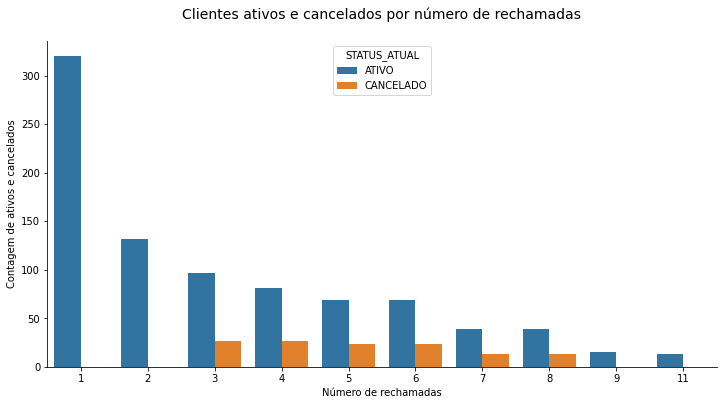

In [23]:
ax = sns.countplot(x="RECHAMADAS", hue="STATUS_ATUAL", data=data)
ax.figure.set_size_inches(12,6)
ax.set_title('Clientes ativos e cancelados por número de rechamadas\n', fontsize=14)
ax.set_xlabel('Número de rechamadas', fontsize=10)
ax.set_ylabel('Contagem de ativos e cancelados', fontsize=10)
sns.despine(ax=ax);
plt.savefig('My Drive/Colab Notebooks/fig_08.png', format='png', dpi=600, bbox_inches='tight')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


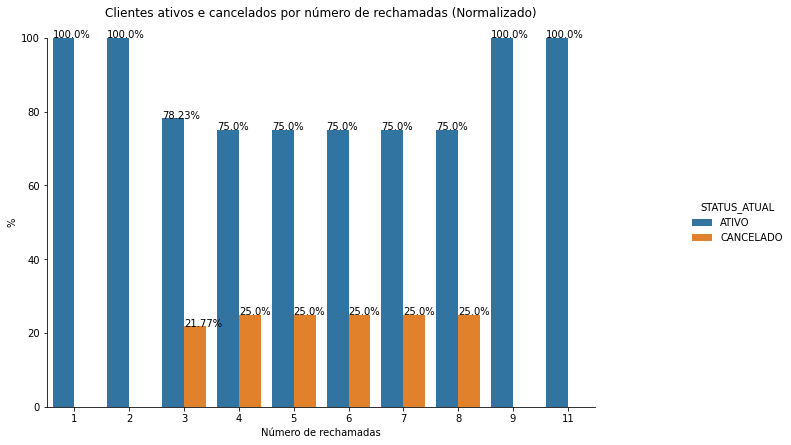

In [24]:
x, y = 'RECHAMADAS', 'STATUS_ATUAL'

aux = data.groupby(x)[y].value_counts(normalize=True)
aux = aux.mul(100)
aux = aux.rename('%').reset_index()

g = sns.catplot(x=x, y='%', hue=y, kind='bar', data=aux)
g.figure.set_size_inches(12,6)
g.set(title="Clientes ativos e cancelados por número de rechamadas (Normalizado)\n", xlabel="Número de rechamadas")
g.ax.set_ylim(0, 100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x, txt_y, txt)

plt.savefig('My Drive/Colab Notebooks/fig_09.png', format='png', dpi=600, bbox_inches='tight')

A proporção entre clientes ativos e cancelados no conjunto de dados se mantém estável em todas as categorias em que há registro de churn.

In [25]:
data.loc[data['STATUS_ATUAL'] == 'ATIVO']['RECHAMADAS'].mean()

3.227688787185355

Na média, um cliente ativo (independentemente de qualquer outro atributo), apresenta 3.22 rechamadas.

In [26]:
data.loc[data['STATUS_ATUAL'] == 'CANCELADO']['RECHAMADAS'].mean()

5.055555555555555

Já um cliente perdido apresenta 5.05 rechamadas. Essa pode ser uma informação importante. Exemplo: Se chegar à quarta ligação sem uma solução e, for um cliente de alto valor, realizar um acionamento preventivo.

In [27]:
data.loc[data['SEGMENTO ']=='POS_PAGO'].groupby('STATUS_ATUAL')['RECHAMADAS'].mean()

STATUS_ATUAL
ATIVO        4.0
CANCELADO    3.0
Name: RECHAMADAS, dtype: float64

Dentro do segmento "PÓS-PAGO", ainda que o número de registros seja menor que o segmento "CONTROLE", essa tolerância é menor: são em média 3 rechamadas.

In [28]:
data.loc[data['SEGMENTO ']=='CONTROLE'].groupby('STATUS_ATUAL')['RECHAMADAS'].mean()

STATUS_ATUAL
ATIVO        2.989521
CANCELADO    5.213675
Name: RECHAMADAS, dtype: float64

E acima, o segmento "CONTROLE".